# Imports

In [ ]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import json

In [ ]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


# Reading the data

In [ ]:
if not os.path.exists('./SVHN'):
  import gdown
  url = 'https://drive.google.com/uc?id=1YneBiiNWt6mEa5STYWtT5XlDb_6JeDpg'
  gdown.download(url, './SVHN.zip', quiet=False)
  !unzip ./SVHN.zip > /dev/null

Downloading...
From: https://drive.google.com/uc?id=1YneBiiNWt6mEa5STYWtT5XlDb_6JeDpg
To: /content/SVHN.zip
689MB [00:18, 36.9MB/s]


# making the joson file for bounding boxes

In [ ]:
# import tqdm
# import h5py
# import optparse
# from json import JSONEncoder

# parser = optparse.OptionParser()
# parser.add_option("-f", dest="fin", help="Matlab full number SVHN input file", default="digitStruct.mat")
# parser.add_option("-o", dest="filePrefix", help="name for the json output file", default="digitStruct")
# options, args = parser.parse_args()

# fin = options.fin


# # The DigitStructFile is just a wrapper around the h5py data.  It basically references
# #    inf:              The input h5 matlab file
# #    digitStructName   The h5 ref to all the file names
# #    digitStructBbox   The h5 ref to all struc data
# class DigitStructFile:
#     def __init__(self, inf):
#         self.inf = h5py.File(inf, 'r')
#         self.digitStructName = self.inf['digitStruct']['name']
#         self.digitStructBbox = self.inf['digitStruct']['bbox']

#     # getName returns the 'name' string for for the n(th) digitStruct.
#     def getName(self, n):
#         return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

#     # bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox.
#     def bboxHelper(self, attr):
#         if len(attr) > 1:
#             attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
#         else:
#             attr = [attr.value[0][0]]
#         return attr

#     # getBbox returns a dict of data for the n(th) bbox.
#     def getBbox(self, n):
#         bbox = {}
#         bb = self.digitStructBbox[n].item()
#         bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
#         bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
#         bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
#         bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
#         bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
#         return bbox

#     def getDigitStructure(self, n):
#         s = self.getBbox(n)
#         s['name'] = self.getName(n)
#         return s

#     # getAllDigitStructure returns all the digitStruct from the input file.
#     def getAllDigitStructure(self):
#         print('Starting get all digit structure')
#         return [self.getDigitStructure(i) for i in tqdm.tqdm(range(len(self.digitStructName)))]

#     # Return a restructured version of the dataset (one structure by boxed digit).
#     #
#     #   Return a list of such dicts :
#     #      'filename' : filename of the samples
#     #      'boxes' : list of such dicts (one by digit) :
#     #          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
#     #          'left', 'top' : position of bounding box
#     #          'width', 'height' : dimension of bounding box
#     #
#     # Note: We may turn this to a generator, if memory issues arise.
#     def getAllDigitStructure_ByDigit(self):
#         pictDat = self.getAllDigitStructure()
#         result = []
#         structCnt = 1
#         print('Starting pack josn dict')
#         for i in tqdm.tqdm(range(len(pictDat))):
#             item = {'filename': pictDat[i]["name"] }
#             figures = []
#             for j in range(len(pictDat[i]['height'])):
#                 figure = dict()
#                 figure['height'] = pictDat[i]['height'][j]
#                 figure['label']  = pictDat[i]['label'][j]
#                 figure['left']   = pictDat[i]['left'][j]
#                 figure['top']    = pictDat[i]['top'][j]
#                 figure['width']  = pictDat[i]['width'][j]
#                 figures.append(figure)
#             structCnt += 1
#             item['boxes'] = figures
#             result.append(item)
#         return result

# fin = "SVHN/train/digitStruct.mat"
# dsf = DigitStructFile(fin)
# dataset = dsf.getAllDigitStructure_ByDigit()
# fout = open(options.filePrefix + ".json", 'w')
# fout.write(JSONEncoder(indent=True).encode(dataset))
# fout.close()

# DataLoader

In [ ]:
batch_size = 64

train_svhn = datasets.SVHN('./data', split="train", download=True, transform=transforms.ToTensor())
train_cifar = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
train_cifar.targets = np.asarray(train_cifar.targets)
train_cifar.targets[:] = 10
trainset = torch.utils.data.ConcatDataset((train_cifar, train_svhn))

test_svhn = datasets.SVHN('./data', split="test", download=True, transform=transforms.ToTensor())
test_cifar = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())
test_cifar.targets = np.asarray(test_cifar.targets)
test_cifar.targets[:] = 10
testset = torch.utils.data.ConcatDataset((test_cifar, test_svhn))

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=1)

# for (test_data, test_target) in train_loader:
#     break
# print(test_data.shape)
# print(test_target)

Extracting ./data/cifar-10-python.tar.gz to ./data


Files already downloaded and verified


# Train

In [ ]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    def loss_fun(output, target):
        return F.nll_loss(torch.log(output), target)
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            # print('here')
            # print(target.shape)
            # print(target.)
            # print(output.shape)
            output = torch.reshape(output, (output.shape[0],-1))
           # print(output.shape)
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
                output = torch.reshape(output, (output.shape[0],-1))
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

# Network

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 20, kernel_size = 5, padding = 0), #28*28*20
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.MaxPool2d(2,stride=2),
            nn.BatchNorm2d(num_features=20),

            nn.Conv2d(20, 30 ,kernel_size = 3, padding = 0), #12*12*30
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.MaxPool2d(2), #the size is 6*6*16
            nn.BatchNorm2d(num_features=30),
       
            nn.Conv2d(30, 300 ,kernel_size = 6, padding = 0),#1*1*30
            nn.ReLU(),

            nn.Conv2d(1*1*300 , 11 ,kernel_size = 1, padding = 0),
            nn.Softmax(dim=1),

            )

    def forward(self, x):

      x = self.convolutional(x)
      #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
    #  x = x.view(x.size(0), -1)
      #...
      return x

In [ ]:
model = Network()
model.to(device)
#Initialize the optimizer

#optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.1)

In [ ]:
out = train(model, optimizer,5)


Loss train: 0.856	 test: 0.859	 Accuracy train: 75.9%	 test: 77.7%



Loss train: 0.561	 test: 0.750	 Accuracy train: 86.5%	 test: 82.9%



Loss train: 0.556	 test: 0.812	 Accuracy train: 87.2%	 test: 82.3%



Loss train: 0.588	 test: 0.866	 Accuracy train: 86.9%	 test: 79.6%



Loss train: 0.618	 test: 0.916	 Accuracy train: 86.2%	 test: 79.6%



# data loader for actual size data





In [ ]:
class SVHN(torch.utils.data.Dataset):
    def __init__(self, transform, data_path='SVHN/test'):
        'Initialization'
        self.transform = transform
        self.image_paths = glob.glob(data_path + '/*.png')
       # print(self.image_paths)
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
       # print(image_path)
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
       # y = self.name_to_label[c]
        X = self.transform(image)
        return X

In [ ]:


window_transform = transforms.Compose([
                                    transforms.ToTensor()])

batch_size = 1

window_testset = SVHN( transform=window_transform)
window_loader = DataLoader(window_testset, batch_size=batch_size, shuffle=False, num_workers=3)

In [ ]:
next(iter(window_loader))

tensor([[[[0.6784, 0.6706, 0.6588,  ..., 0.2471, 0.2471, 0.9961],
          [0.7843, 0.7843, 0.7725,  ..., 0.2745, 0.2667, 0.9961],
          [0.7882, 0.7882, 0.7882,  ..., 0.3176, 0.3137, 0.9961],
          ...,
          [0.7765, 0.7765, 0.7765,  ..., 0.2000, 0.2314, 0.9882],
          [0.7608, 0.7608, 0.7608,  ..., 0.2235, 0.2549, 0.9882],
          [0.7216, 0.7216, 0.7216,  ..., 0.2431, 0.2745, 0.9961]],

         [[0.5961, 0.5882, 0.5804,  ..., 0.2588, 0.2549, 1.0000],
          [0.6941, 0.6941, 0.6941,  ..., 0.2863, 0.2784, 1.0000],
          [0.7020, 0.7020, 0.6941,  ..., 0.3294, 0.3255, 1.0000],
          ...,
          [0.6627, 0.6627, 0.6627,  ..., 0.2314, 0.2510, 1.0000],
          [0.6588, 0.6588, 0.6588,  ..., 0.2471, 0.2706, 1.0000],
          [0.6510, 0.6510, 0.6549,  ..., 0.2510, 0.2824, 1.0000]],

         [[0.2392, 0.2314, 0.2314,  ..., 0.2235, 0.2353, 0.9843],
          [0.3176, 0.3176, 0.3216,  ..., 0.2510, 0.2510, 0.9843],
          [0.2667, 0.2667, 0.2706,  ..., 0

# window

In [ ]:
def window(model):
    def loss_fun(output, target):
        return F.nll_loss(torch.log(output), target)

      #Comput the test accuracy
    test_loss = []
    test_correct = 0
    model.eval()
    for data in window_loader:
      print('new image')
      data= data.to(device)
      
      # print(data.size())
      with torch.no_grad():
        try:
          print(data.size())
          output = model(data)
          print(output.size())
          windows = []
          classes = []
          for IM in range(output.size()[1]):
            out = output[:, IM, :, :]
            # print('out.argmax()  ' , out.argmax(2).shape)
            # print(' torch.nax ' , torch.max(out))
            # print(out)
            if(torch.max(out) > 0.6):
              classes.append(IM)
              windows.append(out)
              print(IM)
        except:
          continue


In [ ]:
window(model)

# try for one

In [ ]:
data_path = 'SVHN/train'

temp = glob.glob(data_path + '/*.png')
batch_size = 1

temp_loader = DataLoader(temp, batch_size=batch_size, shuffle=True, num_workers=3)

['SVHN/train/20169.png']
torch.Size([33, 70, 3])


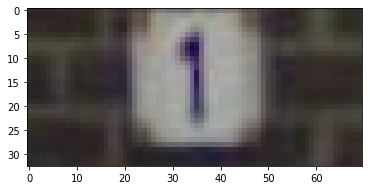

In [ ]:
temp = next(iter(temp_loader))
print(temp)

temp2 = torch.tensor(np.array(Image.open(temp[0])))
print(temp2.shape)

plt.imshow(temp2)

In [ ]:
temp3 = temp2.permute((2,0,1)).unsqueeze(0).type(torch.cuda.FloatTensor)
temp3.shape

NameError: ignored

In [ ]:
print(model(temp3.to(device)).shape)
print(0, np.amax(model(temp3.to(device))[0][0].cpu().detach().numpy()))
print(1, np.amax(model(temp3.to(device))[0][1].cpu().detach().numpy()))
print(2, np.amax(model(temp3.to(device))[0][2].cpu().detach().numpy()))
print(3, np.amax(model(temp3.to(device))[0][3].cpu().detach().numpy()))
print(4, np.amax(model(temp3.to(device))[0][4].cpu().detach().numpy()))
print(5, np.amax(model(temp3.to(device))[0][5].cpu().detach().numpy()))
print(6, np.amax(model(temp3.to(device))[0][6].cpu().detach().numpy()))
print(7, np.amax(model(temp3.to(device))[0][7].cpu().detach().numpy()))
print(8, np.amax(model(temp3.to(device))[0][8].cpu().detach().numpy()))
print(9, np.amax(model(temp3.to(device))[0][9].cpu().detach().numpy()))

torch.Size([1, 11, 1, 10])
0 0.9749531
1 0.99968827
2 0.06343373
3 0.07030655
4 0.06777282
5 0.06159344
6 0.24498865
7 0.0605367
8 0.07400352
9 0.36754164


In [ ]:
out = model(temp3.to(device)).cpu().detach().numpy()
out = out[0]

y = out.shape[1]
x = out.shape[2]

for i in np.arange(10):
  print(i)

  for j in y:
    for k in x:
      if out[][][]

out.shape


(11, 1, 10)

In [ ]:
np.set_printoptions(suppress=True)

out = model(temp3.to(device))[0][3].cpu().detach().numpy()

from numpy import unravel_index

print('highest value in conv.:', np.amax(out))
print('coordinates of highest value in conv.:',unravel_index(out.argmax(), out.shape))
print('shape of conv.:',out.shape)
print('shape of orig.:',temp2.permute((2,0,1)).numpy()[0].shape)
#out

highest value in conv.: 0.07030655
coordinates of highest value in conv.: (0, 5)
shape of conv.: (1, 10)
shape of orig.: (33, 70)


In [ ]:
out9 = model(temp3.to(device))[0][9].cpu().detach().numpy()
#print(out9)

print('highest value in conv.:', np.amax(out9))
print('coordinates of highest value in conv.:',unravel_index(out.argmax(), out9.shape))
print('shape of conv.:',out9.shape)
print('shape of orig.:',temp2.permute((2,0,1)).numpy()[0].shape)
#out

highest value in conv.: 0.672119
coordinates of highest value in conv.: (1, 10)
shape of conv.: (3, 16)
shape of orig.: (41, 92)


In [ ]:
h_orig = temp2.permute((2,0,1)).numpy()[0].shape[0]
w_orig = temp2.permute((2,0,1)).numpy()[0].shape[1]

h_conv = out.shape[0]
w_conv = out.shape[1]

y_conv = unravel_index(out.argmax(), out.shape)[0]
x_conv = unravel_index(out.argmax(), out.shape)[1]

y_orig = int((h_orig / h_conv) * y_conv)
x_orig = int((w_orig / w_conv) * x_conv)

center = (y_orig, x_orig)

center

(0, 28)

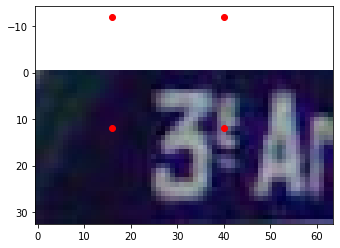

In [ ]:
plt.imshow(temp2)

plt.plot(x_orig-12,y_orig-12,'ro') 
plt.plot(x_orig-12,y_orig+12,'ro') 
plt.plot(x_orig+12,y_orig-12,'ro') 
plt.plot(x_orig+12,y_orig+12,'ro') 

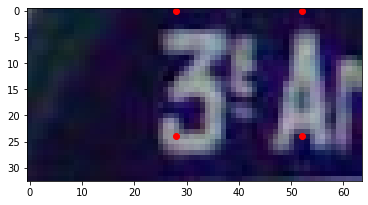

In [ ]:
plt.imshow(temp2)

plt.plot(x_orig,y_orig,'ro') 
plt.plot(x_orig,y_orig+24,'ro') 
plt.plot(x_orig+24,y_orig,'ro') 
plt.plot(x_orig+24,y_orig+24,'ro') 

In [ ]:
print(x_conv*4+19,y_conv*4+19) 
print(x_conv*4+19,y_conv*4+51) 
print(x_conv*4+51,y_conv*4+19) 
print(x_conv*4+51,y_conv*4+51) 

59 23
59 55
91 23
91 55


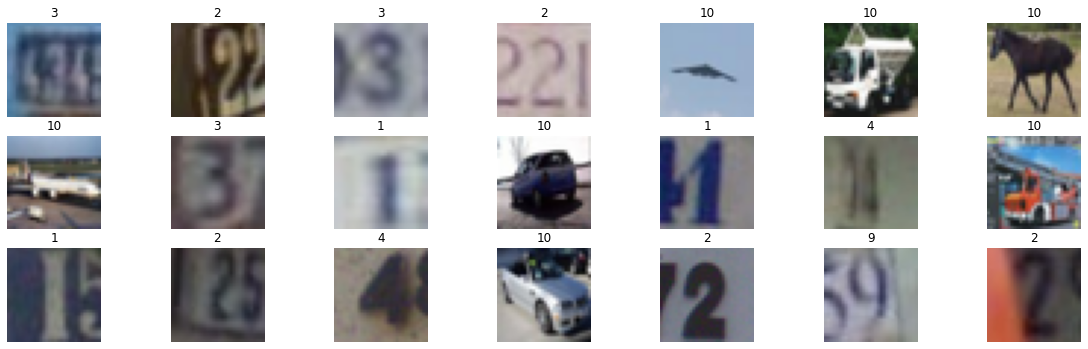

In [ ]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title([0,1,2,3,4,5,6,7,8,9,10][labels[i].item()])
    plt.axis('off')